In [ ]:
import numpy as np

import dismech


geom = dismech.GeomParams(rod_r0=1e-3,
                          shell_h=0,
                          )

material = dismech.Material(density=1000,
                            youngs_rod=10e6,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

threeD_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=50,
                                  total_time=100,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()

r0 = geom.rod_r0
lambda_ = 0.05  # Pitch of the flagellum
mu = 1  # Viscosity of the fluid
Ct = 2 * np.pi * mu / ( np.log(2 * lambda_ / r0) - 0.5) # Tangential coefficient based on Gray and Hancock
Cn = 4 * np.pi * mu / ( np.log(2 * lambda_ / r0) + 0.5) # Perpendicular coefficient based on Gray and Hancock
env.add_force('rft', ct=Ct, cn=Cn)
#env.set_static()

# geo = dismech.Geometry.from_txt('../tests/resources/flagella/flagellum_n20.txt')
geo = dismech.Geometry.from_txt('../tests/resources/flagella/flagellum_n50.txt')

robot = dismech.SoftRobot(geom, material, geo, threeD_sim, env)

In [2]:
print(Cn)
print(Ct)

2.461498864200349
1.5305541603672292


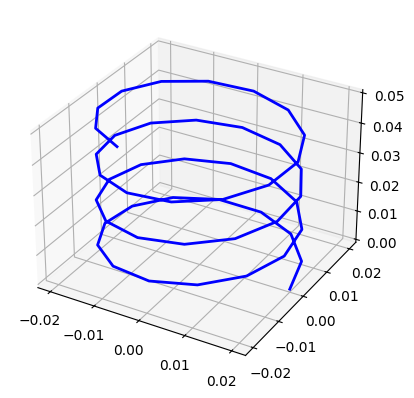

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(robot.nodes[:,0], robot.nodes[:,1], robot.nodes[:,2], color='b', linewidth=2)

plt.show()

In [4]:
stepper = dismech.ImplicitEulerTimeStepper(robot)

In [5]:
robot = robot.fix_nodes([0,1])
robot = robot.fix_edges([0,1])

In [ ]:
# def rotate_flagella(robot: dismech.SoftRobot, t: float):
#     rpm = 10
#     w0 = rpm * 2 * np.pi / 60  # Base angular velocity
#     robot = robot.twist_edges([1], w0 * robot.sim_params.dt)
#     return robot

def rotate_flagella(robot: dismech.SoftRobot, t: float):
    omega = 0.1  # Base angular velocity
    # Apply boundary conditions on two nodes
    omega_angle = omega * t

    node0_t0 = np.array([0.02,0,0])
    node1_t0 = np.array([0.0176558035697561,0.00939534992994868,0.00263157894736842])

    # move node 0
    move_node_0_to = np.array([
    node0_t0[0] * np.cos(omega_angle) + node0_t0[1] * np.sin(omega_angle),
    - node0_t0[0] * np.sin(omega_angle) + node0_t0[1] * np.cos(omega_angle),
    node0_t0[2]  # z remains unchanged
    ])
    # print(f"Moving node 0 to {move_node_0_to}")
    robot = robot.move_nodes_to([0], move_node_0_to)

    # move node 1
    move_node1_to = np.array([
    node1_t0[0] * np.cos(omega_angle) + node1_t0[1] * np.sin(omega_angle),
    - node1_t0[0] * np.sin(omega_angle) + node1_t0[1] * np.cos(omega_angle),
    node1_t0[2]
    ])
    # print(f"Moving node 1 to {move_node1_to}")
    robot = robot.move_nodes_to([1], move_node1_to)
    return robot

stepper.before_step = rotate_flagella
robots = stepper.simulate(robot)

qs = np.stack([robot.state.q for robot in robots])

1.0816338154646647
0.13685417770102004
0.5089469905782142
0.008927369353726462
0.015348678418348366
1.769689564254243e-05
current_time:  0.01
0.008205845451908542
0.025393015468995857
2.274483290130769e-05
current_time:  0.02
0.007067793822321484
0.009327410162513494
5.493069869598854e-06
current_time:  0.03
0.006660177968038507
0.0048299641592321465
2.094290064121979e-06
current_time:  0.04
0.006545590189422097
0.002951970783735869
1.1997268814681768e-06
current_time:  0.05
0.006483924892135906
0.0019931676423060895
current_time:  0.06
0.006444868165743065
0.0014340606054039128
current_time:  0.07
0.00641753733231923
0.0010781355725442792
current_time:  0.08
0.006397412912928696
0.0008370937276129604
current_time:  0.09
0.0063819528052915415
0.0006661900645725149
current_time:  0.1
0.006369692385221193
0.0005406465069267384
current_time:  0.11
0.00635972638416867
0.00044578579414762
current_time:  0.12
0.0063514639308554655
0.0003724413650705103
current_time:  0.13
0.00634450231627060

In [7]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Flagella', plot_step=100)

# fig = dismech.get_interactive_animation_plotly(robot, t, qs, options)
# fig.show()

1001


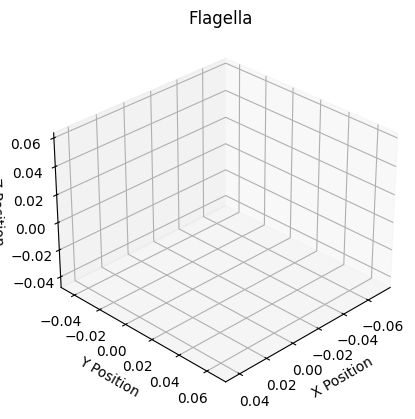

In [8]:
ani = dismech.get_animation(robot, t, qs, options)
ani.save('flagella.gif')

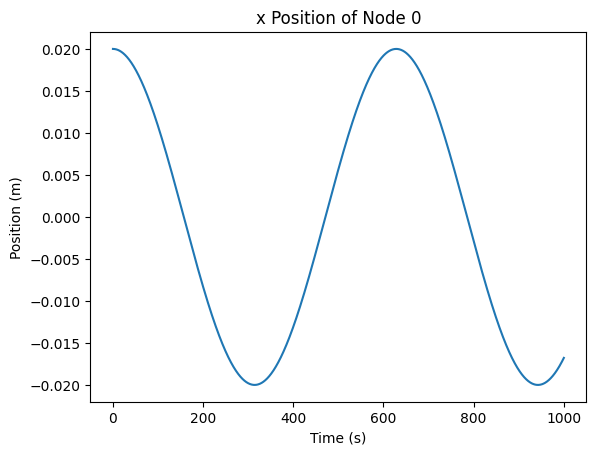

In [9]:
import matplotlib.pyplot as plt
plt.title("x Position of Node 0")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.plot(t, qs[:, 0])
plt.show()